In [1]:
import os, codecs
import pandas as pd
import numpy as np

%pylab inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

from matplotlib import font_manager as fm, rcParams
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
os.listdir()

['.DS_Store',
 '.ipynb_checkpoints',
 '1数据分析.ipynb',
 '2潮汐点分析.ipynb',
 'baseline.ipynb',
 'Data',
 'readme.md']

In [4]:
PATH = 'Data/'

def bike_fence_format(s):
    s = s.replace('[', '').replace(']', '').split(',')
    s = np.array(s).astype(float).reshape(5, -1)
    return s


# 共享单车停车点位（电子围栏）数据
bike_fence = pd.read_csv(PATH + 'gxdc_tcd.csv')
bike_fence['FENCE_LOC'] = bike_fence['FENCE_LOC'].apply(bike_fence_format)

# 共享单车订单数据
bike_order = pd.read_csv(PATH + 'gxdc_dd.csv')
bike_order = bike_order.sort_values(['BICYCLE_ID', 'UPDATE_TIME'])

In [5]:
import geohash
bike_order['geohash'] = bike_order.apply(lambda x: 
                        geohash.encode(x['LATITUDE'], x['LONGITUDE'], precision=9), axis=1)

In [6]:
from geopy.distance import geodesic

bike_fence['MIN_LATITUDE'] = bike_fence['FENCE_LOC'].apply(lambda x: np.min(x[:, 1]))
bike_fence['MAX_LATITUDE'] = bike_fence['FENCE_LOC'].apply(lambda x: np.max(x[:, 1]))

bike_fence['MIN_LONGITUDE'] = bike_fence['FENCE_LOC'].apply(lambda x: np.min(x[:, 0]))
bike_fence['MAX_LONGITUDE'] = bike_fence['FENCE_LOC'].apply(lambda x: np.max(x[:, 0]))

bike_fence['FENCE_AREA'] = bike_fence.apply(lambda x: geodesic(
    (x['MIN_LATITUDE'], x['MIN_LONGITUDE']), (x['MAX_LATITUDE'], x['MAX_LONGITUDE'])
).meters, axis=1)

bike_fence['FENCE_CENTER'] = bike_fence['FENCE_LOC'].apply(
    lambda x: np.mean(x[:-1, ::-1], 0)
)

In [7]:
import geohash
bike_order['geohash'] = bike_order.apply(
    lambda x: geohash.encode(x['LATITUDE'], x['LONGITUDE'], precision=6), 
axis=1)

bike_fence['geohash'] = bike_fence['FENCE_CENTER'].apply(
    lambda x: geohash.encode(x[0], x[1], precision=6)
)

In [8]:
# bike_order
geohash.encode(24.521156, 118.140385, precision=6), \
geohash.encode(24.521156, 118.140325, precision=6)

('wsk52r', 'wsk52r')

In [9]:
bike_order['UPDATE_TIME'] = pd.to_datetime(bike_order['UPDATE_TIME'])
bike_order['DAY'] = bike_order['UPDATE_TIME'].dt.day.astype(object)
bike_order['DAY'] = bike_order['DAY'].apply(str)

bike_order['HOUR'] = bike_order['UPDATE_TIME'].dt.hour.astype(object)
bike_order['HOUR'] = bike_order['HOUR'].apply(str)
bike_order['HOUR'] = bike_order['HOUR'].str.pad(width=2,side='left',fillchar='0')

bike_order['DAY_HOUR'] = bike_order['DAY'] + bike_order['HOUR']

In [10]:
bike_inflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 1], 
                   values='LOCK_STATUS', index=['geohash'],
                    columns=['DAY_HOUR'], aggfunc='count', fill_value=0
)

bike_outflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 0], 
                   values='LOCK_STATUS', index=['geohash'],
                    columns=['DAY_HOUR'], aggfunc='count', fill_value=0
)

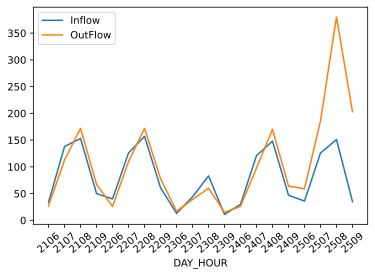

In [11]:
bike_inflow.loc['wsk52r'].plot()
bike_outflow.loc['wsk52r'].plot()
plt.xticks(list(range(bike_inflow.shape[1])), bike_inflow.columns, rotation=40)
plt.legend(['Inflow', 'OutFlow'])

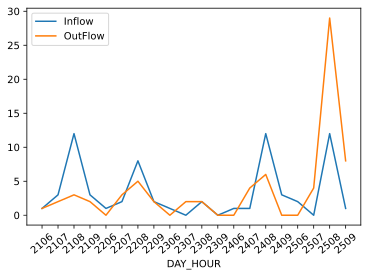

In [12]:
bike_inflow.loc['wsk596'].plot()
bike_outflow.loc['wsk596'].plot()
plt.xticks(list(range(bike_inflow.shape[1])), bike_inflow.columns, rotation=40)
plt.legend(['Inflow', 'OutFlow'])

In [13]:
bike_inflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 1], 
                   values='LOCK_STATUS', index=['geohash'],
                    columns=['DAY'], aggfunc='count', fill_value=0
)

bike_outflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 0], 
                   values='LOCK_STATUS', index=['geohash'],
                    columns=['DAY'], aggfunc='count', fill_value=0
)

In [23]:
bike_order.head()

,BICYCLE_ID,LATITUDE,LONGITUDE,LOCK_STATUS,UPDATE_TIME,geohash,DAY,HOUR,DAY_HOUR,fence
34481,0000ff105fd5f9099b866bccd157dc50,24.521156,118.140385,0,2020-12-21 06:32:48,wsk52r,21,06,2106,枋湖北二路0_L_4
41110,0000ff105fd5f9099b866bccd157dc50,24.496578,118.142543,1,2020-12-21 06:50:18,wsk527,21,06,2106,金安路_L_A02001
66106,0000ff105fd5f9099b866bccd157dc50,24.496582,118.142612,0,2020-12-21 08:23:32,wsk527,21,08,2108,金安路_L_A02001
65945,0000ff105fd5f9099b866bccd157dc50,24.481350,118.167496,1,2020-12-21 08:44:34,wsk52b,21,08,2108,前埔路0_L_A02007
3547,0000ff105fd5f9099b866bccd157dc50,24.509607,118.155216,0,2020-12-22 08:00:44,wsk52t,22,08,2208,云顶北路_L_14


In [14]:
bike_remain = (bike_inflow - bike_outflow).fillna(0)
bike_remain[bike_remain < 0] = 0  
bike_remain = bike_remain.sum(1)
bike_fence['DENSITY'] = bike_fence['geohash'].map(bike_remain).fillna(0)

In [16]:
import hnswlib
import numpy as np

p = hnswlib.Index(space='l2', dim=2)
p.init_index(max_elements=300000, ef_construction=1000, M=32)
p.set_ef(1024)
p.set_num_threads(14)

p.add_items(np.stack(bike_fence['FENCE_CENTER'].values))

In [17]:
index, dist = p.knn_query(bike_order[['LATITUDE','LONGITUDE']].values[:], k=1)
bike_order['fence'] = bike_fence.iloc[index.flatten()]['FENCE_ID'].values

In [27]:
bike_order.head() # 利用每个车辆的停车点，找到与之对应的最近的围栏点，与每个订单相对应

,BICYCLE_ID,LATITUDE,LONGITUDE,LOCK_STATUS,UPDATE_TIME,geohash,DAY,HOUR,DAY_HOUR,fence
34481,0000ff105fd5f9099b866bccd157dc50,24.521156,118.140385,0,2020-12-21 06:32:48,wsk52r,21,06,2106,枋湖北二路0_L_4
41110,0000ff105fd5f9099b866bccd157dc50,24.496578,118.142543,1,2020-12-21 06:50:18,wsk527,21,06,2106,金安路_L_A02001
66106,0000ff105fd5f9099b866bccd157dc50,24.496582,118.142612,0,2020-12-21 08:23:32,wsk527,21,08,2108,金安路_L_A02001
65945,0000ff105fd5f9099b866bccd157dc50,24.481350,118.167496,1,2020-12-21 08:44:34,wsk52b,21,08,2108,前埔路0_L_A02007
3547,0000ff105fd5f9099b866bccd157dc50,24.509607,118.155216,0,2020-12-22 08:00:44,wsk52t,22,08,2208,云顶北路_L_14


In [18]:
# 然后统计每个停车点的进流量和出流量

bike_inflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 1], 
                   values='LOCK_STATUS', index=['fence'],
                    columns=['DAY'], aggfunc='count', fill_value=0
)

bike_outflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 0], 
                   values='LOCK_STATUS', index=['fence'],
                    columns=['DAY'], aggfunc='count', fill_value=0
)

bike_remain = (bike_inflow - bike_outflow).fillna(0)
bike_remain[bike_remain < 0] = 0  
bike_remain = bike_remain.sum(1)

In [28]:
bike_remain

fence
七星西路0_L_1    23.0
七星西路0_L_2     4.0
七星西路0_L_3     0.0
七星西路0_R_1     2.0
七星西路0_R_2    10.0
             ... 
龙虎西二里_L_1     1.0
龙虎西二里_L_2     1.0
龙虎西二里_L_3     0.0
龙虎西二里_L_4     0.0
龙虎西二里_R_1     0.0
Length: 13482, dtype: float64

In [29]:
bike_fence.set_index('FENCE_ID')['FENCE_AREA']

FENCE_ID
长乐路0_L_A17001     6.039052
长乐路0_L_A17002     6.039053
长乐路0_L_A17003     6.188997
长乐路0_L_A17004     6.039051
长乐路0_L_A17005     7.196632
                   ...    
龙虎西二里_L_1        15.136775
龙虎西二里_L_2        19.317500
龙虎西二里_L_3        14.201846
龙虎西二里_L_4        13.458712
龙虎西二里_R_1        14.200283
Name: FENCE_AREA, Length: 14071, dtype: float64

In [19]:
# bike_fence = bike_fence.set_index('FENCE_ID')
bike_density = bike_remain / bike_fence.set_index('FENCE_ID')['FENCE_AREA'] # 车辆数除以电子围栏的面积就是密度

bike_density = bike_density.sort_values(ascending=False).reset_index()
bike_density = bike_density.fillna(0)

In [55]:
(bike_remain / bike_fence.set_index('FENCE_ID')['FENCE_AREA']).sort_values(ascending=False).fillna(0)
# 可以看出是升序排的，然后取密度最大的前40个区域

观日路(望海路至会展路段 )_R_1      132.677037
象屿路0_R_1                103.337121
望海路0_R_2                 84.258024
望海路0_R_1                 66.347128
云顶北路0_R_45               52.947930
                           ...    
鹭江道0_L_A10014             0.000000
鹭江道0_L_A10019             0.000000
龙山东路(龙山南路至盘龙路段 )_L_1      0.000000
龙山北路_L_A03002             0.000000
龙虎山路_L_14                 0.000000
Length: 14071, dtype: float64

In [56]:
(bike_remain / bike_fence.set_index('FENCE_ID')['FENCE_AREA']).sort_values(ascending=False).fillna(0).reset_index()
# reset_index的作用

,index,0
0,观日路(望海路至会展路段 )_R_1,132.677037
1,象屿路0_R_1,103.337121
2,望海路0_R_2,84.258024
3,望海路0_R_1,66.347128
4,云顶北路0_R_45,52.947930
...,...,...
14066,鹭江道0_L_A10014,0.000000
14067,鹭江道0_L_A10019,0.000000
14068,龙山东路(龙山南路至盘龙路段 )_L_1,0.000000
14069,龙山北路_L_A03002,0.000000


In [20]:
bike_density['label'] = '0'
bike_density.iloc[:100, -1] = '1'

bike_density['BELONG_AREA'] ='厦门'
bike_density = bike_density.drop(0, axis=1)

In [57]:
bike_density

,FENCE_ID,FENCE_TYPE,BELONG_AREA
0,观日路(望海路至会展路段 )_R_1,1,厦门
1,象屿路0_R_1,1,厦门
2,望海路0_R_2,1,厦门
3,望海路0_R_1,1,厦门
4,云顶北路0_R_45,1,厦门
...,...,...,...
14066,鹭江道0_L_A10014,0,厦门
14067,鹭江道0_L_A10019,0,厦门
14068,龙山东路(龙山南路至盘龙路段 )_L_1,0,厦门
14069,龙山北路_L_A03002,0,厦门


In [21]:
bike_density.columns = ['FENCE_ID', 'FENCE_TYPE', 'BELONG_AREA']
bike_density.to_csv('result.txt', index=None, sep='|')

In [60]:
bike_density.to_csv('reslut1.txt', sep='|')

In [63]:
pd.read_table('reslut1.txt', sep='|').head(3) # 如果不设置index=None的话，写入文件就会有index

,Unnamed: 0,FENCE_ID,FENCE_TYPE,BELONG_AREA
0,0,观日路(望海路至会展路段 )_R_1,1,厦门
1,1,象屿路0_R_1,1,厦门
2,2,望海路0_R_2,1,厦门
